## Part A)
Use the stub file $\texttt{FD.m}$ to create a function for the Frequent Directions algorithm ($\textbf{Algorithm 16.2.1}$).  We will consider running this code on matrix $\texttt{A.dat}$.  

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import math
from numpy.random import normal
import matplotlib.pyplot as plt
from scipy.linalg import svd

In [156]:
l = 4

In [2]:
def ReadFile(filename):
    matrix = []

    lines = [line.rstrip('\n') for line in open(filename)]

    for line in lines:
        matrix.append(line.split())

    return np.asarray(matrix,dtype= float)

In [3]:
def FrequentDirections(A, l):
    n, m = np.shape(A)
    
    if np.floor(l/2) >= m:
        raise ValueError("Error: \'l\' must be smaller than m*2")
    if l >= n:
        raise ValueError("Error: \'l\' must not be greater than n")
        
    # Initialize output matrix B
    B = np.zeros([l,m])
    
     # Compute zero valued row list
    zero_rows = np.nonzero([round(s, 4) == 0.0 for s in np.sum(B, axis = 1)])[0].tolist()
    
    # Repeat inserting each row of matrix A
    for i in range(n):
        if len(zero_rows) > 0:
            # Insert a row into matrix B
            B[zero_rows[0], :] = A[i, :]

            # Remove zero valued row from the list
            zero_rows.remove(zero_rows[0])

        # If there is no more zero valued rows
        elif len(zero_rows) == 0:

            # Compute SVD of matrix B
            U, s, V = svd(B, full_matrices=False)

            # Obtain squared singular value for threshold
            sq_sv_center = s[int(np.floor(l/2))]**2

            # Update sigma to shrink the row norms
            sigma_tilda = [(0.0 if d < 0.0 else np.sqrt(d)) for d in (s**2 - sq_sv_center)]

            # Update matrix B where at least half the rows are all zero
            B = np.dot(np.diagflat(sigma_tilda), V)

            # Update the zero valued row list
            zero_rows = np.nonzero([round(s, 4) == 0.0 for s in np.sum(B, axis = 1)])[0].tolist()
    return B

In [4]:
A = ReadFile('A.dat')
trials = 10

We can measure the error $\max_{\|x\|=1} | \|A x\|^2 - \|B x\|^2 |$ as 
$\texttt{norm(A'*A - B'*B, 2)}$.  
* How large does $\texttt{l}$ need to be for the above error to be at most $\|A\|_F^2 /10$?

In [293]:
rand_proj_norm = []
for l in range(1, trials):
    B = FrequentDirections(A, l*2)
    rand_proj_norm.append(norm(np.dot(A.T, A) - np.dot(B.T, B),2))
    
threshold = np.full(trials-1, norm(A,'fro')**2/10)

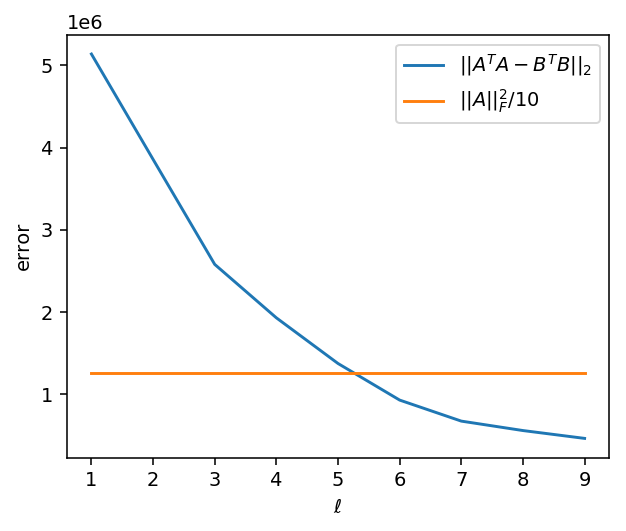

In [297]:
fig=plt.figure(figsize=(5, 4), dpi= 140)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.plot(np.arange(1,trials),rand_proj_norm,label="$\\left|\\left| A^{T}A - B^{T}B\\right|\\right|_{2}$")
plt.plot(np.arange(1,trials),threshold,label="$\\left|\\left| A\\right|\\right|_{F}^{2}/10$")
plt.xlabel("$\ell$")
plt.ylabel("error")
plt.legend(loc="best")
plt.show()

* How does this compare to the theoretical bound (e.g. for $k=0$).  

In [277]:
def topKSVD(A, k):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    S = np.diag(S)
    Uk, Sk, Vk = U[:, :k], S[:k, :k], V[:k]
    Ak = np.dot(Uk, np.dot(Sk, Vk))
    return Ak

In [287]:
trials = 30

In [288]:
rand_proj_norm = []
threshold = []
for l in range(1, trials):
    B = FrequentDirections(A, l*2)
    rand_proj_norm.append(norm(np.dot(A.T, A) - np.dot(B.T, B),2))
    threshold.append(norm(A - topKSVD(A, k=0),'fro')**2/(l))

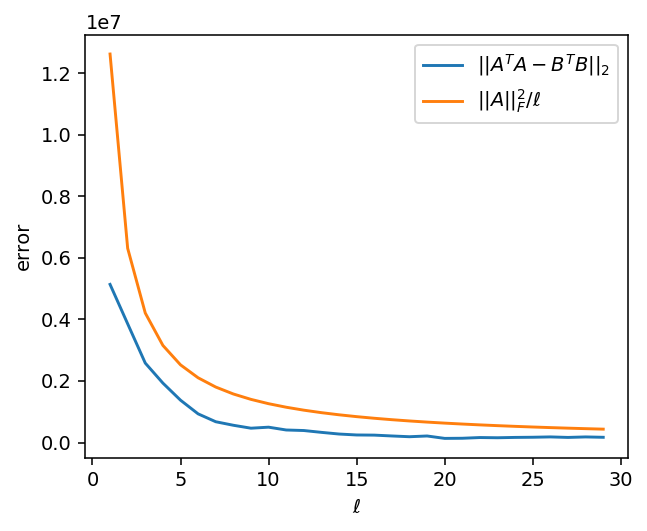

In [289]:
fig=plt.figure(figsize=(5, 4), dpi= 140)
plt.plot(np.arange(1,trials),rand_proj_norm,label="$\\left|\\left| A^{T}A - B^{T}B\\right|\\right|_{2}$")
plt.plot(np.arange(1,trials),threshold,label="$\\left|\\left| A\\right|\\right|_{F}^{2}/\\ell$")
plt.xlabel("$\ell$")
plt.ylabel("error")
plt.legend(loc="best")
plt.show()

* How large does $\texttt{l}$ need to be for the above error to be at most $\|A - A_k\|_F^2/10$ (for $k=2$)?

In [314]:
trials = 15

In [315]:
rand_proj_norm = []
threshold = []
for l in range(1, trials):
    B = FrequentDirections(A, l*2)
    rand_proj_norm.append(norm(np.dot(A.T, A) - np.dot(B.T, B),2))
    
threshold = np.full(trials-1, norm(A - topKSVD(A, k=2),'fro')**2/(10))

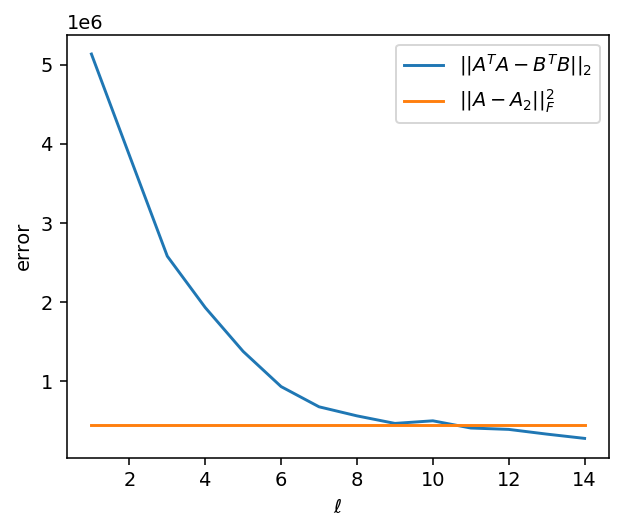

In [319]:
fig=plt.figure(figsize=(5, 4), dpi= 140)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.plot(np.arange(1,trials),rand_proj_norm,label="$\\left|\\left| A^{T}A - B^{T}B\\right|\\right|_{2}$")
plt.plot(np.arange(1,trials),threshold,label="$\\left|\\left| A-A_{2}\\right|\\right|_{F}^{2}$")
plt.xlabel("$\ell$")
plt.ylabel("error")
plt.legend(loc="best")
plt.show()

In [317]:
Ak = topKSVD(A, k=2)
A_ = norm(A - Ak)**2
err = A_
l = 0

while err > A_/10:
    l += 1
    B = FrequentDirections(A, l*2)
    err = norm(np.dot(A.T, A) - np.dot(B.T, B),2)

print("Minimum l: ", l)

Minimum l:  11


## Part B)
Create another $\texttt{l x d}$ matrix $B$, but using random projections.  You can do this by creating an $\texttt{l x n}$ matrix $\texttt{S}$, and letting $\texttt{B = SA}$.  Fill each entry of $\texttt{S}$ by an independent normal random variable $S_{i,j} = \frac{1}{\sqrt{\texttt{l}}} N(0,1)$.  

Estimate how large should $\texttt{l}$ be in order to achieve $\max_{\|x\|=1} | \|A x\|^2 - \|B x\|^2 | \leq \|A\|_F^2/10$.  To estimate the relationship between $\texttt{l}$ and the error in this randomized algorithm, you will need to run multiple trials.  Be sure to describe how you used these multiple trials, and discuss how many you ran and why you thought this was enough trials to run to get a good estimate.  


In [5]:
def RandomVals(l,d):
    return 1.0/np.sqrt(l) * np.asarray([normal() for i in range(d)])

In [21]:
l_vals = []
for i in range(300):
    l = 0
    A_ = norm(A)**2/10
    err = norm(A)*norm(A)
    while err > A_:
        l += 1
        S = [RandomVals(l, np.shape(A)[0]) for i in range(l)]    
        S = np.asarray(S)
        B = np.dot(S, A)
        err = norm(np.dot(A.T, A) - np.dot(B.T, B),2)
    l_vals.append(int(l))

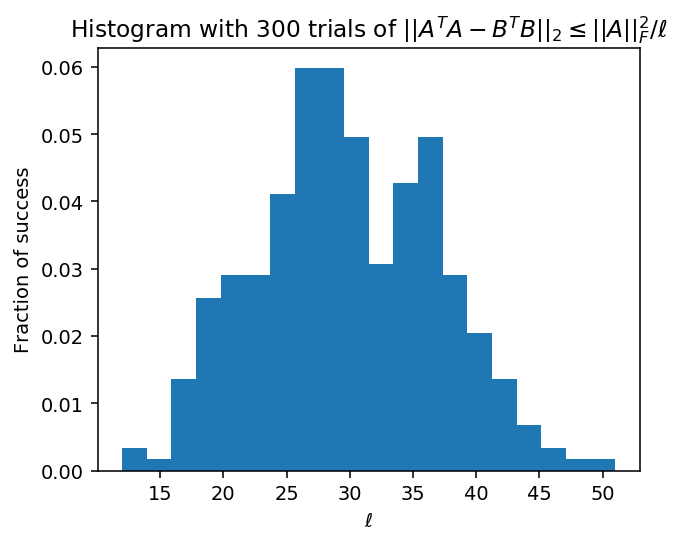

In [23]:
fig=plt.figure(figsize=(5, 4), dpi= 140)
plt.xlabel("$\ell$")
plt.ylabel("Fraction of success")
plt.title ('Histogram with 300 trials of $\\left|\\left| A^{T}A - B^{T}B\\right|\\right|_{2} \leq \\left|\\left| A\\right|\\right|_{F}^{2}/\\ell$')
plt.hist(l_vals, normed=True, bins=20)
plt.show()